In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd
import pylab
from scipy.signal import find_peaks

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:3168: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


# Read excel

In [39]:
df_power = pd.read_excel('118-phase-powers-v3.xlsx')
df_power['mep_by_cmap_log'] = np.log(df_power['mep_by_cmap'])
df_power['mep_size_log'] = np.log(df_power['mep_size'])
for channel in ['C4', 'C3', 'LTM1']:
    df_power[channel + '_beta_power_abs'] = np.abs(df_power[channel + '_beta_power'])
    df_power[channel + '_mu_power_abs'] = np.abs(df_power[channel + '_mu_power'])
df_power.shape

(1726, 987)

In [40]:
# channel = 'LTM1'
# band = 'mu'
# df_power2 = df_power[((df_power[channel + '_'+band+'_phase'] + 180 >= 45) & (df_power[channel + '_'+band+'_phase'] + 180 <= 135) | ((df_power[channel + '_'+band+'_phase'] + 180 >= 225) & (df_power[channel + '_'+band+'_phase'] + 180 > 315)))]
# df_power2[channel + '_'+band+'_phase_cat'] = df_power2[channel + '_'+band+'_phase'].apply(lambda x: 0 if x < 135 else 1)
# df_power2.to_excel('116-lmm-v1.xlsx')

# Interaction plot

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Troughs')

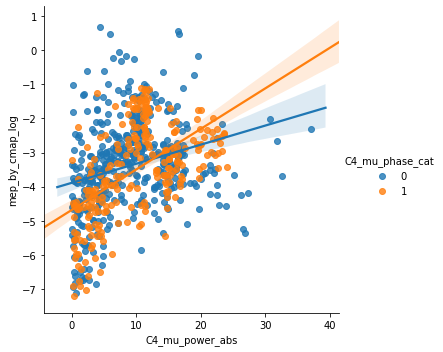

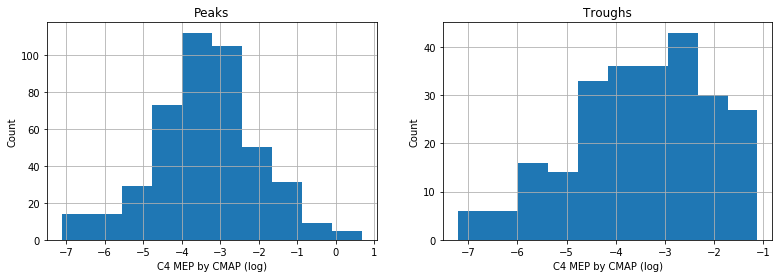

In [20]:
channel = 'C4'
band = 'mu'
df_power2 = df_power[((df_power[channel + '_'+band+'_phase'] >= 45) & (df_power[channel + '_'+band+'_phase'] <= 135) | ((df_power[channel + '_'+band+'_phase'] >= 225) & (df_power[channel + '_'+band+'_phase'] > 315)))]
df_power2[channel + '_'+band+'_phase_cat'] = df_power2[channel + '_'+band+'_phase'].apply(lambda x: 0 if x < 135 else 1)

sns.lmplot(x=channel + '_' + band + '_power_abs', y="mep_by_cmap_log", hue=channel + '_'+band+'_phase_cat', data=df_power2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
df_power2[df_power2[channel + '_'+band+'_phase_cat'] == 0]['mep_by_cmap_log'].hist(ax=ax1)
ax1.set_xlabel(channel + ' MEP by CMAP (log)')
ax1.set_ylabel('Count')
ax1.set_title('Peaks')

df_power2[df_power2[channel + '_'+band+'_phase_cat'] == 1]['mep_by_cmap_log'].hist(ax=ax2)
ax2.set_xlabel(channel + ' MEP by CMAP (log)')
ax2.set_ylabel('Count')
ax2.set_title('Troughs')